In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [416]:
file_path = '/Users/corablomberg/Desktop/Datasets/GLEAM_LivestockEmissions.csv'
gleam = pd.read_csv(file_path)

<div style="border:1px solid black; padding:10px;">

## Data Overview: 
### GLEAM livestock emissions, 
<strong> Data from UN-FAO's Global Livestock Environmental Assessment Model (GLEAM)</strong> 

This Kaggle dataset is designed for analyzing the environmental impact of livestock through their greenhouse gas emissions (CO2, CH4, N2O) and different production systems. The dataset allows the calculation of emission intensity across livestock types as well as the emission contributions along each phase of the life cycle (e.g., feed production, manure management, transport). Through effective analysis and communication of various scale-factors, the livestock species that have the worst environmental impacts will be revealed, as well as the greatest opportunities for growth in the livestock industry. 
</div>

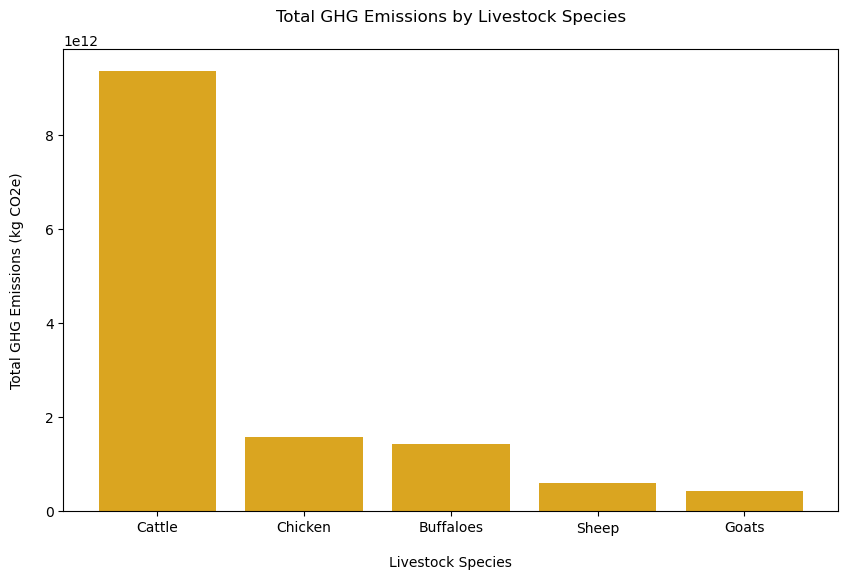

In [390]:
# Filter and group for animal species and aggregate ghg emissions
filtered_gleam = gleam[(gleam['Production system'] == 'Aggregated') & 
                            (gleam['Commodity'] == 'Aggregated')]
filtered_gleam = filtered_gleam.groupby('Animal species', as_index=False)['Total GHG emissions (kg CO2e)'].sum()
filtered_gleam = filtered_gleam.sort_values(by='Total GHG emissions (kg CO2e)', ascending=False)

# Plot the chart
fig, gleam1 = plt.subplots(figsize=(10, 6))

gleam1.bar(filtered_gleam['Animal species'], filtered_gleam['Total GHG emissions (kg CO2e)'], color='goldenrod')

gleam1.set_xlabel('Livestock Species', labelpad=15)
gleam1.set_ylabel('Total GHG Emissions (kg CO2e)', labelpad=15)
gleam1.set_title('Total GHG Emissions by Livestock Species', pad=20)

plt.show()

<div style="border:1px solid black; padding:10px;">
    <strong>Total GhG Emissions for each Livestock type: </strong> 
The above graph shows that Cattle, are by far the highest contributor to greenhouse gas emissions, among other common livestock types. It is important to note that these results (for cattle and chicken particularly), are the result of a high population (high kg of production) for these types of livestock. Take a look at how this compares to Emission Intensity in the next visualization.
        
</div>

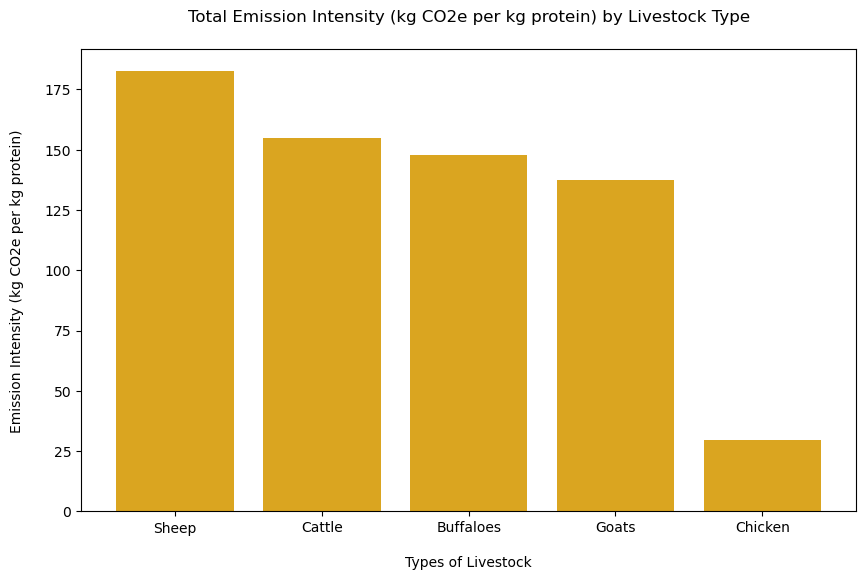

In [482]:
filtered_ei = gleam[(gleam['Production system'] == 'Aggregated') & 
                       (gleam['Commodity'] == 'Aggregated')]

# Group by Animal species and find average emission intensity
grouped_ei = filtered_ei.groupby('Animal species').agg({
    'Emission Intensity (kg CO2e per kg protein)': 'mean'}).reset_index()

grouped_ei = grouped_ei.sort_values(by='Emission Intensity (kg CO2e per kg protein)', ascending=False)

# Create plot
fig, gleam2 = plt.subplots(figsize=(10,6))
bars = gleam2.bar(grouped_ei['Animal species'], 
                  grouped_ei['Emission Intensity (kg CO2e per kg protein)'], 
                  color='goldenrod')
gleam2.set_xlabel('Types of Livestock', labelpad=15)
gleam2.set_ylabel('Emission Intensity (kg CO2e per kg protein)', labelpad=15)
gleam2.set_title('Total Emission Intensity (kg CO2e per kg protein) by Livestock Type', pad=20)

plt.show()

<div style="border:1px solid black; padding:10px;">
    <strong>Emission Intensity for each Livestock type: </strong> 
Emission Intensity is defined by the amount of emissions per kg of production. Therefore, this visualization normalizes the impact of each livestock type to the kilogram. Note that Sheep, on average, contribute more to emissions per 1 kg of sheep, than cattle contribute per 1 kg of cattle. The significant difference of emissions between the two species from the last visualization, gives testament to the fact that far more cattle are in livestock production than sheep. This visualization helps us understand that sheep, cattle, buffaloes, and goats, all have high emission intensities, while chicken has low emissions intensity (emissions per kg). Also note that, while chicken has a low emission intensity, it is still second highest in total emissions (previous visualization) due to its high quantity of production. 
</div>

In [572]:
ei_table = gleam[(gleam['Production system'] == 'Aggregated') & 
            (gleam['Commodity'] == 'Aggregated')]

# Group by Animal species and calculate the average emission intensity
ei_table = ei_table.groupby('Animal species').agg({
    'Emission Intensity (kg CO2e per kg protein)': 'mean'}).reset_index()
ei_table['Emission Intensity (kg CO2e per kg protein)'] = ei_table['Emission Intensity (kg CO2e per kg protein)'].round(2)

# Emission intensity in descending order
ei_table_sorted = ei_table.sort_values(by='Emission Intensity (kg CO2e per kg protein)', ascending=False).reset_index(drop=True)

ei_table_sorted

,Animal species,Emission Intensity (kg CO2e per kg protein)
0,Sheep,182.45
1,Cattle,155.00
2,Buffaloes,147.60
3,Goats,137.38
4,Chicken,29.56


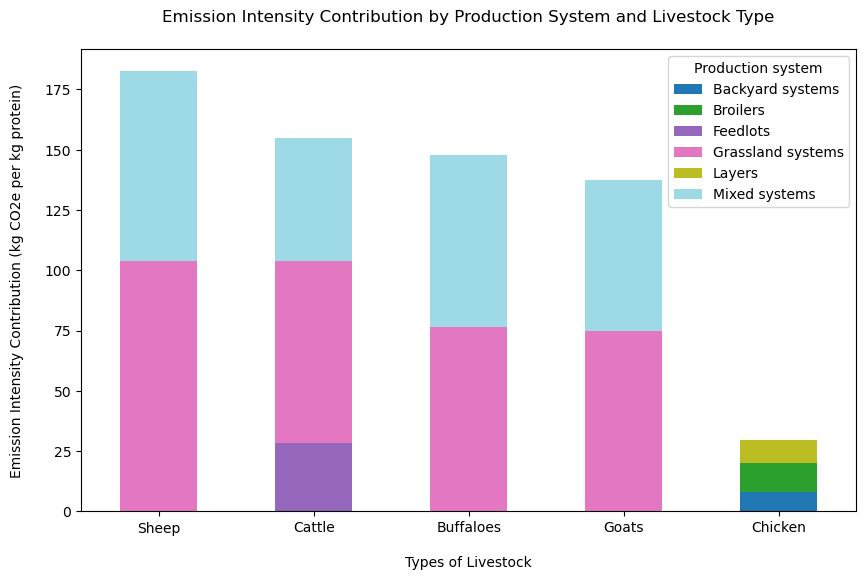

In [402]:
filtered_production = gleam[(gleam['Production system'] != 'Aggregated') & 
                            (gleam['Commodity'] == 'Aggregated')]

# Group by Animal species and Production system and calculate the average emission intensity
avg_emission_by_species_prod = filtered_production.groupby(['Animal species', 'Production system'])['Emission Intensity (kg CO2e per kg protein)'].mean().reset_index()

# Calculate the overall average emission intensity for each livestock type (using aggregated data)
# Group by Animal species to calculate the average emission intensity for each livestock type
filtered_livestock = gleam[(gleam['Production system'] == 'Aggregated') & 
                           (gleam['Commodity'] == 'Aggregated')]
avg_emission_by_species = filtered_livestock.groupby('Animal species')['Emission Intensity (kg CO2e per kg protein)'].mean().reset_index()


# For each livestock type, calculate the emission intensity proportion to be applied to the aggregated emission intensity
stacked_data = []

for index, row in avg_emission_by_species.iterrows():
    species = row['Animal species']
    total_emission = row['Emission Intensity (kg CO2e per kg protein)']
    
    # Filter the average emission intensities for this specific livestock type
    species_prod_data = avg_emission_by_species_prod[avg_emission_by_species_prod['Animal species'] == species]
    
    # Calculate the total emission intensity for the livestock type across all production systems
    total_species_emission = species_prod_data['Emission Intensity (kg CO2e per kg protein)'].sum()
    
    # Calculate the proportion for each production system and apply to the total emission intensity
    for _, prod_row in species_prod_data.iterrows():
        prod_system = prod_row['Production system']
        prod_emission = prod_row['Emission Intensity (kg CO2e per kg protein)']
        
        # Proportion of this production system for this species
        proportion = prod_emission / total_species_emission
        
        # Contribution of this production system to the total emission intensity for the livestock type
        emission_contribution = total_emission * proportion
        stacked_data.append({
            'Animal species': species,
            'Production system': prod_system,
            'Emission Contribution (kg CO2e per kg protein)': emission_contribution
        })

stacked_df = pd.DataFrame(stacked_data)


# Create stacked bar chart
pivot_stacked = stacked_df.pivot(index='Animal species', columns='Production system', values='Emission Contribution (kg CO2e per kg protein)').fillna(0)

# Sort by total emission intensity in descending order & drop emission intensity column as it will mess things up
pivot_stacked['Total Emission Intensity'] = pivot_stacked.sum(axis=1)
pivot_sorted = pivot_stacked.sort_values(by='Total Emission Intensity', ascending=False)
pivot_sorted = pivot_sorted.drop(columns=['Total Emission Intensity'])

fig, gleam4 = plt.subplots(figsize=(10, 6))
pivot_sorted.plot(kind='bar', stacked=True, ax=gleam4, cmap='tab20')

gleam4.set_xlabel('Types of Livestock', labelpad=15)
gleam4.set_ylabel('Emission Intensity Contribution (kg CO2e per kg protein)', labelpad=15)
gleam4.set_title('Emission Intensity Contribution by Production System and Livestock Type', pad=20)

plt.xticks(rotation=0)

plt.show()

<div style="border:1px solid black; padding:10px;">
    <strong>Emission Intensity for each Livestock type: </strong> 
Continuing with emission intensity for a normalized comparison; this visualization breaks down the production systems that make up each livestock type by color. Mixed systems in blue, refer to production systems that grow crops in concunction with livestock production. Mixed systems, along with grassland systems (where livestock are free to roam and graze) contribute the most to emissions. Note that sheep, buffalo, and goats only have mixed and grassland systems of production, which may indicate that production is not industrialized-- which may be due to approaches of the underdeveloped world. Cattle, however, has a noteworthy contribution of Feedlots which are known as compact, feeding stalls to mass-produce livestock as quickly as possible. Chicken has a similar production type known as Broilers, which make up over 30% of the livestock's total emission intensity. Secondly, chickens are the only livestock type that can be solely produced for eggs, or "Layers" systems, which make up a significant portion of the overal emission intensity. Thirdly, chickens are the only livestock that can be produced in Backyard systems, likely due to their size.  
</div>

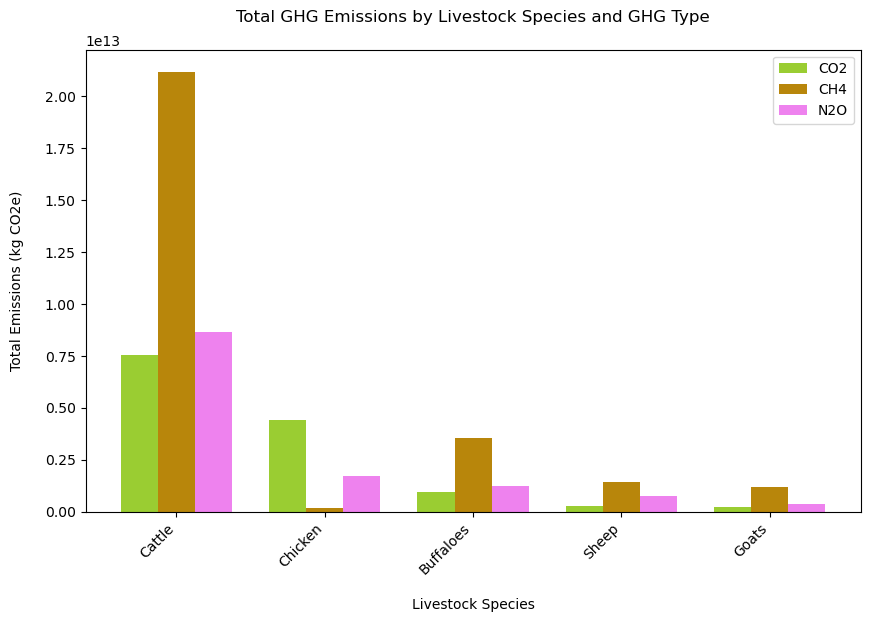

In [404]:
# Clean dataset and aggregate ghgs
gleam_ghgs = gleam[gleam['Animal species'] != 'Pigs']

gleam_ghgs = gleam_ghgs.groupby('Animal species', as_index=False).agg({
    'Total CO2 emissions (kg CO2e)': 'sum',
    'Total CH4 emissions (kg CO2e)': 'sum',
    'Total N2O emissions (kg CO2e)': 'sum'
})

# Sort the species by total GHG emissions in descending order
gleam_ghgs['Total GHG emissions'] = gleam_ghgs['Total CO2 emissions (kg CO2e)'] + \
                                    gleam_ghgs['Total CH4 emissions (kg CO2e)'] + \
                                    gleam_ghgs['Total N2O emissions (kg CO2e)']
gleam_ghgs_sorted = gleam_ghgs.sort_values(by='Total GHG emissions', ascending=False)

# Create the plot
bar_width = 0.25
x = range(len(gleam_ghgs_sorted['Animal species']))

fig, gleam5 = plt.subplots(figsize=(10, 6))

gleam5.bar([p - bar_width for p in x], gleam_ghgs_sorted['Total CO2 emissions (kg CO2e)'], width=bar_width, label='CO2', color='yellowgreen')
gleam5.bar(x, gleam_ghgs_sorted['Total CH4 emissions (kg CO2e)'], width=bar_width, label='CH4', color='darkgoldenrod')
gleam5.bar([p + bar_width for p in x], gleam_ghgs_sorted['Total N2O emissions (kg CO2e)'], width=bar_width, label='N2O', color='violet')

gleam5.set_xlabel('Livestock Species', labelpad=15)
gleam5.set_ylabel('Total Emissions (kg CO2e)', labelpad=15)
gleam5.set_title('Total GHG Emissions by Livestock Species and GHG Type', pad=20)
gleam5.set_xticks(x)
gleam5.set_xticklabels(gleam_ghgs_sorted['Animal species'], rotation=45, ha='right')

gleam5.legend()

plt.show()

<div style="border:1px solid black; padding:10px;">
    <strong>CH4, CO2, and N2O Emissions for each Livestock type: </strong> 
    Now we will look at Total Emissions (moving away from normalized emission intensity) of each livestock type broken down into three different greenhouse gasses (CO2, NO2, and CH4). CH4 or Methane, known as the emission from manure or enteric fermentation (farts), is by far the number one contributor for cattle, buffaloes, sheep, and goats. Note that N20 and CO2 emissions are indirect contributors (from feed production, processing, housing, and transportation) These emissions are significantly less than methane. Methane has a global warming potential that is 28x that of CO2, therefore, even if the same amount of CO2 and CH4 were emitted per livestock, CH4 will always have a stronger heating effect on the Earth. This explains the significantly higher emissions score of CH4. Notice that chicken has very low methane emissions compared to CO2 and N2O emissions.
</div>

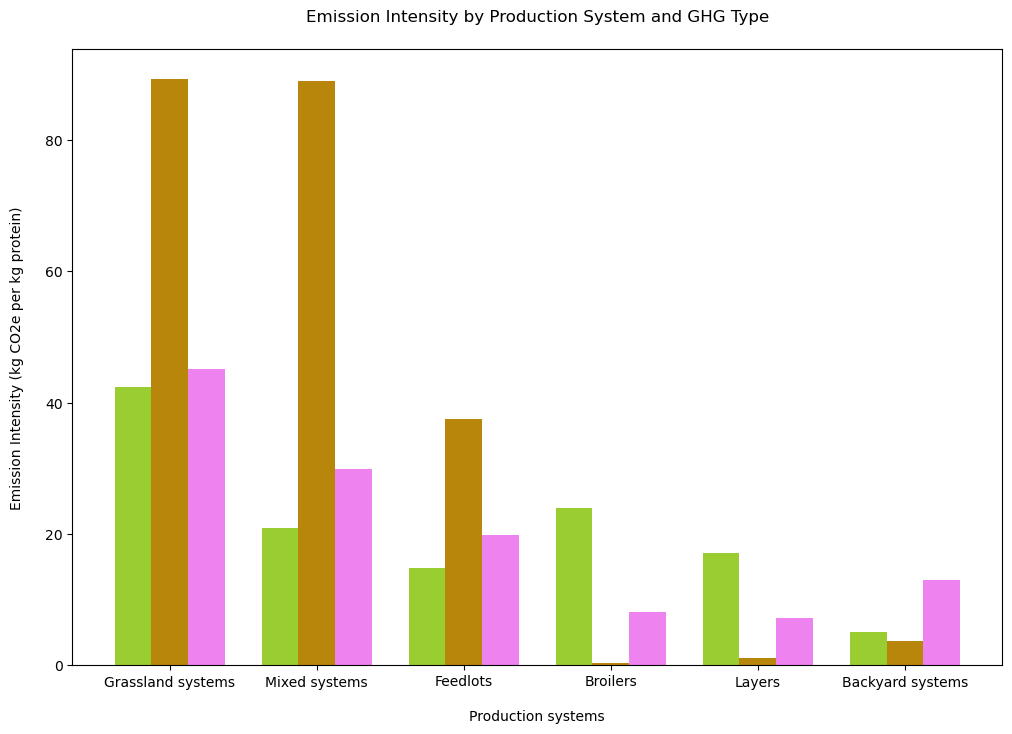

In [588]:
gleam_ghgs_ei = gleam[(gleam['Animal species'] != 'Pigs') & 
                      (gleam['Production system'] != 'Aggregated') &
                      (gleam['Commodity'] == 'Aggregated')]

# Sum ghg emissions by production system
ghg_sums = gleam_ghgs_ei.groupby('Production system', as_index=False).agg({
    'Total CO2 emissions (kg CO2e)': 'sum',
    'Total CH4 emissions (kg CO2e)': 'sum',
    'Total N2O emissions (kg CO2e)': 'sum',
    'Emission Intensity (kg CO2e per kg protein)': 'mean'  # Using mean emission intensity
})

# Calculate total GHG emissions for each production system
ghg_sums['Total GHG emissions'] = ghg_sums['Total CO2 emissions (kg CO2e)'] + \
                                  ghg_sums['Total CH4 emissions (kg CO2e)'] + \
                                  ghg_sums['Total N2O emissions (kg CO2e)']

# Calculate the percentage contribution of each GHG to the total GHG emissions
ghg_sums['CO2 percentage'] = ghg_sums['Total CO2 emissions (kg CO2e)'] / ghg_sums['Total GHG emissions']
ghg_sums['CH4 percentage'] = ghg_sums['Total CH4 emissions (kg CO2e)'] / ghg_sums['Total GHG emissions']
ghg_sums['N2O percentage'] = ghg_sums['Total N2O emissions (kg CO2e)'] / ghg_sums['Total GHG emissions']

# Apply these percentages to the aggregated emission intensity to find the emission intensity for each GHG
ghg_sums['CO2 emission intensity'] = ghg_sums['CO2 percentage'] * ghg_sums['Emission Intensity (kg CO2e per kg protein)']
ghg_sums['CH4 emission intensity'] = ghg_sums['CH4 percentage'] * ghg_sums['Emission Intensity (kg CO2e per kg protein)']
ghg_sums['N2O emission intensity'] = ghg_sums['N2O percentage'] * ghg_sums['Emission Intensity (kg CO2e per kg protein)']

# Create chart in descending order
ghg_sums_sorted = ghg_sums.sort_values(by='Emission Intensity (kg CO2e per kg protein)', ascending=False)

fig, gleam6 = plt.subplots(figsize=(12, 8))

bar_width = 0.25
x = range(len(ghg_sums_sorted['Production system']))

gleam6.bar([p - bar_width for p in x], ghg_sums_sorted['CO2 emission intensity'], width=bar_width, label='CO2 Intensity', color='yellowgreen')
gleam6.bar(x, ghg_sums_sorted['CH4 emission intensity'], width=bar_width, label='CH4 Intensity', color='darkgoldenrod')
gleam6.bar([p + bar_width for p in x], ghg_sums_sorted['N2O emission intensity'], width=bar_width, label='N2O Intensity', color='violet')

gleam6.set_xlabel('Production systems', labelpad=15)
gleam6.set_ylabel('Emission Intensity (kg CO2e per kg protein)', labelpad=15)
gleam6.set_title('Emission Intensity by Production System and GHG Type', pad=20)
gleam6.set_xticks(x)
gleam6.set_xticklabels(ghg_sums_sorted['Production system'])

ax.legend()

plt.show()

<div style="border:1px solid black; padding:10px;">
    <strong>Emission Intensity for each Production System type: </strong> 
    Emission Intensity of CO2, N20, and CH4 by Production System reveals similar information as in the previous visualization: CH4 makes up the majority of emissions for all production systems except those that produce chickens. One difference, is that Mixed systems, that grow crops alongside livestock, emit more N2O in comparison to CO2 than Grassland systems. This is due to fertilizer-use. Note that despite the immense ethical concerns of producing livestock in feedlots, the emission intensity is lower than other systems (remember, this visualization is normalized, unlike the previous visualization). Notice that CO2 is the greatest contributor for Chicken-production systems EXCEPT for Backyard systems: this is due to transportation emissions, and backyard systems not requiring much transportation before consumption. 
</div>

In [430]:
# Define dictionary for LCA phases 
phase_categories = {
    'Feed: fertilizer & crop residues, N2O (kg CO2e)': 'Feed Production',
    'Feed: applied & deposited manure, N2O (kg CO2e)': 'Feed Production',
    'LUC: soy & palm, CO2 (kg CO2e)': 'Feed Production',
    'LUC: pasture expansion, CO2 (kg CO2e)': 'Animal Husbandry',
    'Enteric fermentation, CH4 (kg CO2e)': 'Manure Emissions',
    'Direct energy, CO2 (kg CO2e)': 'Animal Husbandry',
    'Manure management, N2O (kg CO2e)': 'Manure Emissions',
    'Manure management, CH4 (kg CO2e)': 'Manure Emissions',
    'Postfarm': 'Transport/Processing',
    'Indirect energy, CO2 (kg CO2e)': 'Transport/Processing',
}
categories_df = pd.DataFrame(list(phase_categories.items()), columns=['Column', 'Category'])

In [432]:
# Make table to display the emission types that will be going into each LCA phase

categories_df = pd.DataFrame(list(phase_categories.items()), columns=['Column', 'Category'])

# group the columns under each category into lists
grouped_categories = categories_df.groupby('Category')['Column'].apply(list).reset_index()

# Find the max list length for cutting down the visual empty space
max_len = grouped_categories['Column'].apply(len).max()

# Create a df with the category names as columns, and emission types as rows.
# Also reorder the table to match the life cycle.
categories_table = pd.DataFrame({category: pd.Series(emissions) for category, emissions in zip(grouped_categories['Category'], grouped_categories['Column'])})
categories_table = categories_table[['Feed Production', 'Animal Husbandry', 'Manure Emissions', 'Transport/Processing']]

# Fill NaN answers with spaces for cleanliness
categories_table.fillna('', inplace=True) 

categories_styled = categories_table.style.set_caption(" ").set_properties(**{
    'color': 'black',
    'border-color': 'black',
    'text-align': 'right',
})

categories_styled

,Feed Production,Animal Husbandry,Manure Emissions,Transport/Processing
0,"Feed: fertilizer & crop residues, N2O (kg CO2e)","LUC: pasture expansion, CO2 (kg CO2e)","Enteric fermentation, CH4 (kg CO2e)",Postfarm
1,"Feed: applied & deposited manure, N2O (kg CO2e)","Direct energy, CO2 (kg CO2e)","Manure management, N2O (kg CO2e)","Indirect energy, CO2 (kg CO2e)"
2,"LUC: soy & palm, CO2 (kg CO2e)",,"Manure management, CH4 (kg CO2e)",


<div style="border:1px solid black; padding:10px;">
    <strong>Life Cycle Phases for Livestock: </strong> 
    There are 4 stages in the production Livestock: Feed Production, Animal Husbandry (Housing), Manure Emissions, and Transportation (plus industrial processing). Within the dataset, the above emmission categories have been assigned each stage. 'LUC' stands for 'Land-use Change'.
</div>

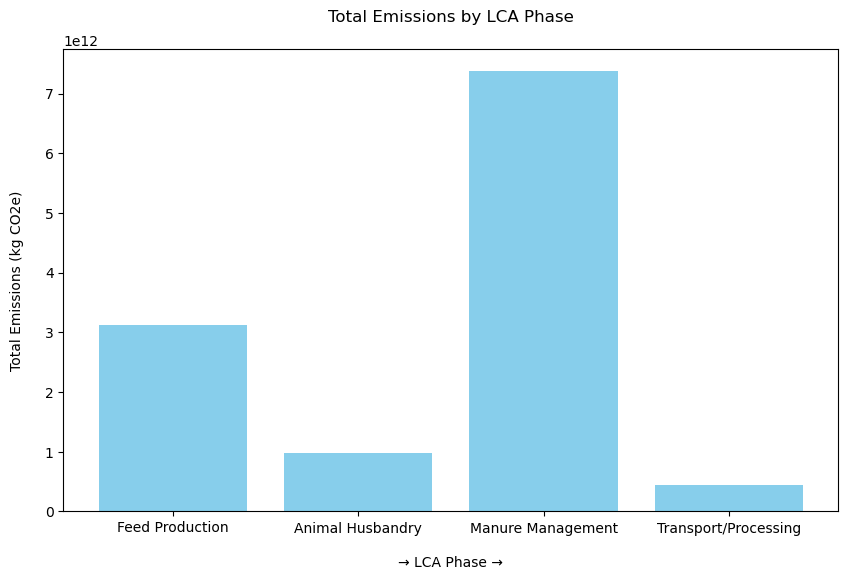

In [596]:
filtered_gleam = gleam[(gleam['Commodity'] == 'Aggregated') & 
                            (gleam['Production system'] == 'Aggregated')]

# Select columns for each LCA phase. Simpler for this case than doing a for-loop 
feed_production_columns = [
    'Feed: fertilizer & crop residues, N2O (kg CO2e)',
    'Feed: applied & deposited manure, N2O (kg CO2e)',
    'LUC: soy & palm, CO2 (kg CO2e)'
]
animal_husbandry_columns = [
    'LUC: pasture expansion, CO2 (kg CO2e)',
    'Direct energy, CO2 (kg CO2e)'
]
manure_emissions_columns = [
    'Manure management, N2O (kg CO2e)',
    'Manure management, CH4 (kg CO2e)',
    'Enteric fermentation, CH4 (kg CO2e)'
]
transport_processing_columns = [
    'Postfarm, CO2 (kg CO2e)',
    'Indirect energy, CO2 (kg CO2e)'
]

# Sum emissions for each LCA phase
emissions_by_phase = {
    'Feed Production': filtered_gleam[feed_production_columns].sum().sum(),
    'Animal Husbandry': filtered_gleam[animal_husbandry_columns].sum().sum(),
    'Manure Management': filtered_gleam[manure_emissions_columns].sum().sum(),
    'Transport/Processing': filtered_gleam[transport_processing_columns].sum().sum()
}

# Convert the dictionary to a df for plotting
emissions_df = pd.DataFrame(list(emissions_by_phase.items()), columns=['LCA Phase', 'Total Emissions'])

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(emissions_df['LCA Phase'], emissions_df['Total Emissions'], color='skyblue')

ax.set_xlabel('\u2192 LCA Phase \u2192', labelpad=15)
ax.set_ylabel('Total Emissions (kg CO2e)', labelpad=15)
ax.set_title('Total Emissions by LCA Phase', pad=20)

plt.show()

<div style="border:1px solid black; padding:10px;">
    <strong> Total Emissions for each LCA phase: </strong> 
    The following visualizations depicts the total emissions for each phase of livestock life cycles. All emmissions are normalized using their global warming potention to kg of CO2. Manure management is the phase that contributes the most to total Ghgs, with Feed Production behind it. Surprisingly, Transport and Processing contributes significantly less Ghg's in proportion. 
</div>

In [424]:
emissions_df

,LCA Phase,Total Emissions
0,Feed Production,3.117815e+12
1,Animal Husbandry,7.491640e+12
2,Manure Emissions,8.617620e+11
3,Transport/Processing,4.375653e+11


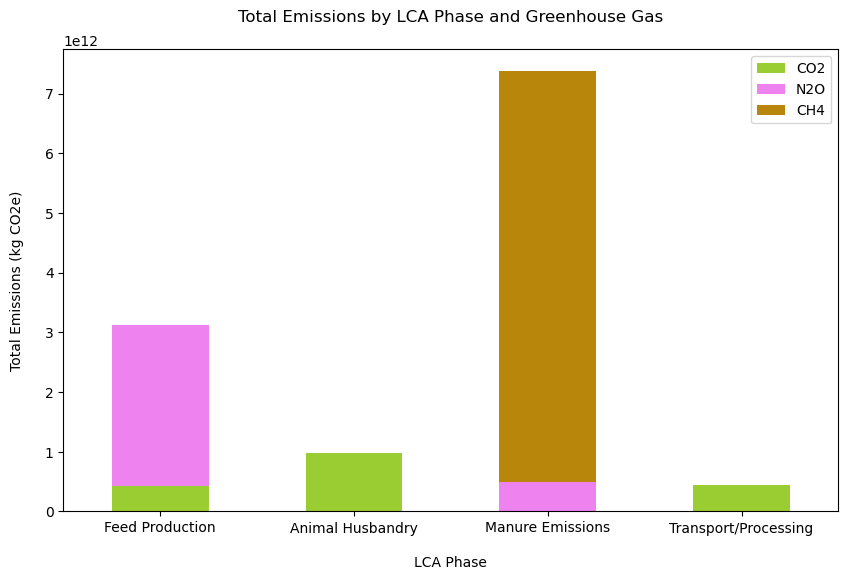

In [452]:
filtered_gleam = gleam[(gleam['Commodity'] == 'Aggregated') & 
                       (gleam['Production system'] == 'Aggregated')]


# Sum emissions for each LCA phase and gas type
emissions_by_phase = {
    'Feed Production': {
        'CO2': filtered_gleam[feed_production_columns_CO2].sum().sum(),
        'N2O': filtered_gleam[feed_production_columns_N2O].sum().sum(),
        'CH4': 0  # No CH4 in Feed Production
    },
    'Animal Husbandry': {
        'CO2': filtered_gleam[animal_husbandry_columns_CO2].sum().sum(),
        'N2O': 0,  # No N2O in Animal Husbandry
        'CH4': 0  # No CH4 in Animal Husbandry
    },
    'Manure Emissions': {
        'CO2': 0,  # No CO2 in Manure Emissions
        'N2O': filtered_gleam[manure_emissions_columns_N2O].sum().sum(),
        'CH4': filtered_gleam[manure_emissions_columns_CH4].sum().sum()
    },
    'Transport/Processing': {
        'CO2': filtered_gleam[transport_processing_columns_CO2].sum().sum(),
        'N2O': 0,  # No N2O in Transport/Processing
        'CH4': 0  
    }
}

# Create a df for the stacked bar chart
emissions_df = pd.DataFrame(emissions_by_phase).T  

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

emissions_df.plot(kind='bar', stacked=True, ax=ax, 
                  color=['yellowgreen','violet', 'darkgoldenrod'],  # Apply the color palette
                  label=['CO2', 'CH4', 'N2O'])

ax.set_xlabel('LCA Phase', labelpad=15)
ax.set_ylabel('Total Emissions (kg CO2e)', labelpad=15)
ax.set_title('Total Emissions by LCA Phase and Greenhouse Gas', pad=20)

plt.xticks(rotation=0, ha='center')

plt.show()

<div style="border:1px solid black; padding:10px;">
    <strong> CO2, N2O, & CH4 Emissions by LCA Phase: </strong> 
    This graph breaks clarifies the emission types that affect each cycle. CH4 is ONLY present in the Manure Management phase, while N2O is primarily present in the Feed Production phase (fertilizer). CO2 dominates Animal Husbandry and Transport/Processing likely due to electricity and fuel. 
</div>

In [456]:
# Create a table to show Ghg stats
total_CO2 = filtered_gleam['Total CO2 emissions (kg CO2e)'].sum()
total_CH4 = filtered_gleam['Total CH4 emissions (kg CO2e)'].sum()
total_N2O = filtered_gleam['Total N2O emissions (kg CO2e)'].sum()

# Calculate the total emissions (sum of all gases)
total_emissions = total_CO2 + total_CH4 + total_N2O

# Calculate the percentage contribution of each gas
CO2_percentage = (total_CO2 / total_emissions) * 100
CH4_percentage = (total_CH4 / total_emissions) * 100
N2O_percentage = (total_N2O / total_emissions) * 100

# Create df to display the results
ghg_table = pd.DataFrame({
    'Greenhouse Gas': ['CO2', 'CH4', 'N2O'],
    'Total Emissions (kg CO2e)': [total_CO2, total_CH4, total_N2O],
    'Percentage of Total (%)': [CO2_percentage, CH4_percentage, N2O_percentage]
})
ghg_table = ghg_table.sort_values(by='Total Emissions (kg CO2e)', ascending=False).reset_index(drop=True)

ghg_table

,Greenhouse Gas,Total Emissions (kg CO2e),Percentage of Total (%)
0,CH4,6.877432e+12,51.307273
1,CO2,3.339459e+12,24.913154
2,N2O,3.187509e+12,23.779572


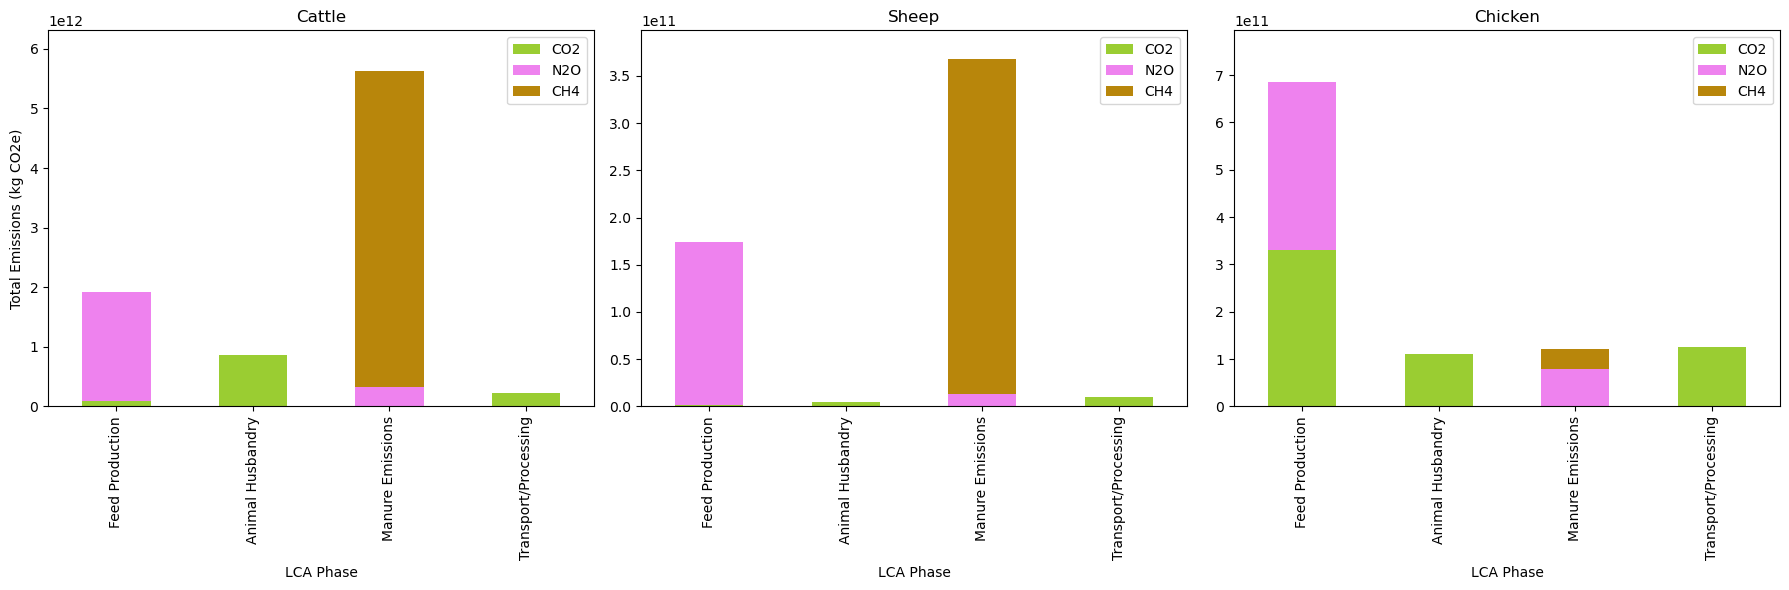

In [552]:
filtered_gleam = filtered_gleam = gleam[(gleam['Commodity'] == 'Aggregated') & 
                       (gleam['Production system'] == 'Aggregated') &
                       (gleam['Animal species'] == 'Chicken') &
                       (gleam['Animal species'] == 'Sheep') &
                       (gleam['Animal species'] == 'Cattle')]

# Function for getting aggregated emission data of each LCA phase for each livestock type
def get_emissions_by_phase(filtered_gleam):
    
    # Sum emissions for each LCA phase and gas type. 
    emissions_by_phase = {
        'Feed Production': {
            'CO2': filtered_gleam[feed_production_columns_CO2].sum().sum(),
            'N2O': filtered_gleam[feed_production_columns_N2O].sum().sum(),
            'CH4': 0  
        },
        'Animal Husbandry': {
            'CO2': filtered_gleam[animal_husbandry_columns_CO2].sum().sum(),
            'N2O': 0,  
            'CH4': 0  
        },
        'Manure Emissions': {
            'CO2': 0,  
            'N2O': filtered_gleam[manure_emissions_columns_N2O].sum().sum(),
            'CH4': filtered_gleam[manure_emissions_columns_CH4].sum().sum()
        },
        'Transport/Processing': {
            'CO2': filtered_gleam[transport_processing_columns_CO2].sum().sum(),
            'N2O': 0,  
            'CH4': 0  
        }
    }

    # Create DataFrame for the emissions
    return pd.DataFrame(emissions_by_phase).T

# Get the emissions data from the dataframe
emissions_cattle = get_emissions_by_phase(filtered_gleam_cattle)
emissions_sheep = get_emissions_by_phase(filtered_gleam_sheep)
emissions_chicken = get_emissions_by_phase(filtered_gleam_chicken)

# Create 3 different plots for each significant livestock type
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
colors = ['yellowgreen', 'violet', 'darkgoldenrod']

# Plot for Cattle
emissions_cattle.plot(kind='bar', stacked=True, ax=axes[0], color=colors)
axes[0].set_title('Cattle')
axes[0].set_xlabel('LCA Phase')
axes[0].set_ylabel('Total Emissions (kg CO2e)')
axes[0].set_ylim([0, 10**12.8]) 

# Plot for Sheep
emissions_sheep.plot(kind='bar', stacked=True, ax=axes[1], color=colors)
axes[1].set_title('Sheep')
axes[1].set_xlabel('LCA Phase')
axes[1].set_ylim([0, 10**11.60]) 

# Plot for Chicken 
emissions_chicken.plot(kind='bar', stacked=True, ax=axes[2], color=colors)
axes[2].set_title('Chicken')
axes[2].set_xlabel('LCA Phase')
axes[2].set_ylim([0, 10**11.9])  

plt.tight_layout()
plt.show()

<div style="border:1px solid black; padding:10px;">
    <strong> CO2, N2O, & CH4 Emissions by LCA Phase for Significant Livestock Species: </strong> 
     The above visualization shows the emmission distribution of each Ghg over the Life-cycle phases for three of the significant species. First: Cattle for their extremely high population and thus great contribution to emissions.  Second: Sheep for coming in first for emission intensity.  And Lastly, Chicken, for their high population as well as their unique profile from the other livestock types. 
    From this visualization, we learn that Cattle and Sheep are very similar in their life cycle of production, and they both mimic the breakdown of the aggregated life cycle emission provile above. Looking at Chicken life cycle, CO2 is much more significant, especially in Feed Production. Manure Mangement is far less significant than other species, and CH4 emissions are low. 
</div>

<div style="border:1px solid black; padding:10px;">

## Summary of Life Cycle Analysis

In this analysis, I examined the greenhouse gas (GHG) emission intensities of different livestock production systems using the GLEAM dataset. Specifically, I focused on emissions of CO2, CH4, and N2O, the three major GHGs contributing to climate change.

### Emission Intensity Breakdown: 
For each production system, I calculated the GHG emissions (CO2, CH4, N2O) and determined the percentage contribution of each gas to the total emissions. These percentages were applied to the aggregated emission intensity values (measured in kg CO2e per kg protein), determining the specific contribution of each GHG to the overall emissions intensity for each system.

### Key Insights

##### 1.Grassland and Mixed systems exhibit the highest total emission intensities, with methane (CH4) being the predominant contributor.

##### 2. Feedlots also displayed significant emissions, but with a more balanced contribution between CO2, CH4, and N2O.

##### 3. Chicken production systems (Broilers, Layers, and Backyard systems) showed relatively lower emission intensities, with CO2 contributing more significantly than methane and nitrous oxide.

## Sustainability Next-Steps for the LCA:

##### 1. Targeting High Emission Systems: The Grassland and Mixed systems have the highest GHG emission intensities. To improve sustainability:

Enteric Fermentation Management: Since CH4 is a major contributor, implementing strategies to reduce methane from enteric fermentation, such as dietary adjustments (e.g., feed additives like seaweed) or improving animal genetics, can significantly reduce emissions.
Pasture Management: Enhancing the quality of pastures through better land management (e.g., rotational grazing, reducing overgrazing) can improve animal productivity and reduce the emission intensity per kg of protein.

##### 2. Feedlot Optimization: Feedlots show significant emissions from a mix of Ghgs. For sustainability:

Manure Management: Improving manure handling and storage systems (e.g., anaerobic digesters to capture methane for energy) can reduce CH4 and N2O emissions.
Energy Use: Implementing renewable energy sources (solar, wind) on feedlot operations can help reduce CO2 emissions from direct and indirect energy use.
Reducing CO2 Emissions in Lower Intensity Systems: For systems like Backyard, Broilers, and Layers, where CO2 contributes most to total emissions:

##### 3. Improving Energy Efficiency: Investing in energy-efficient practices or renewable energy sources for on-farm energy use (e.g., heating, ventilation, and machinery) can reduce CO2 emissions.

Feed Efficiency: Ensuring efficient feed use can minimize the environmental footprint, reducing both CO2 from energy use and CH4 emissions linked to feed production and digestion.
Implementing Carbon Sequestration: Introducing practices that promote carbon sequestration (such as agroforestry or integrating trees into livestock systems) can offset some of the GHG emissions, especially in Grassland systems.

##### 4. Feed Production: Consider emissions from fertilizer use, land-use change, and transportation in feed supply chains.

Post-Farm Gate: Analyze emissions during processing, packaging, transportation, and retail stages to identify additional areas for emission reductions.
Developing Circular Systems: Integrating livestock systems with other agricultural practices can reduce emissions. For instance:

##### 5. Policy Advocacy and Farmer Education. 

Engaging with policymakers to support incentive programs that encourage farmers to adopt sustainable livestock management practices (e.g., subsidies for methane-reducing technologies) can drive industry-wide improvements. Additionally, investing in farmer education programs focused on sustainability can help accelerate the adoption of best practices.

### OPINION: The "Sustainable" Consumer Choice:

Due to their low emission intensity, and comparatively low aggregate emissions, the most sustainable meat choice would be chicken. A vegetarian diet isn't considered in this LCA because other agricultural production emissions were not analyzed for comparison. If one is going to eat red meat, they have to make a moral decision: consume inexpensive meat that is mass produced via unethical means in feedlots that have lower emission intensity, or consume more expensive meat that is produced more ethically in mixed and grassland systems with a much higher emission intensity. My personal moral decision would be to consume ethically sourced red meat, less frequently (Consuming once a week rather than daily). 

</div>